### Sentiment Analysis Pipeline and Multi-Class Text Classification of Twitter Data

**Original Author:** Susan Li.<br/>
**Additional Info:** Multi-Class Text Classification with PySpark. https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35<br/>
**Last Modified:** Team Böhm 30.06.2021

In [1]:
# Install the findspark module
import sys
!{sys.executable} -m pip install findspark

In [2]:
# Install the nltk module
import sys
!{sys.executable} -m pip install nltk

In [3]:
# Install the pyspark module
!{sys.executable} -m pip install pyspark

In [4]:
# Import the SparkSession 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
#from pyspark.sql.functions import col, udf, regexp_replace, trim, lower

# Create SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("currency") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

#Get the spark context
sc = spark.sparkContext

In [5]:
customSchema = StructType([ \
StructField("text", StringType(), True), \
StructField("date", StringType(), True), \
StructField("location", StringType(), True), \
StructField("polarity", StringType(), True), \
StructField("subjectivity", StringType(), True), \
StructField("sentiment", StringType(), True)])

In [6]:
try:
    worldwide_combined_df = spark.read.format("csv") \
       .option("header", "true") \
       .option("sep",",") \
       .schema(customSchema) \
       .load('/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine/worldwide_combined.csv')
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [7]:
try: 
    # Get size and shape of DF
    print((worldwide_combined_df.count(), len(worldwide_combined_df.columns)))
    # Display head of DF (we see some missing values)
    worldwide_combined_df.show(10)
except: 
    print("Unexpected error:", sys.exc_info()[0])

(3606, 6)
+--------------------+--------------------+--------------------+--------+------------+---------+
|                text|                date|            location|polarity|subjectivity|sentiment|
+--------------------+--------------------+--------------------+--------+------------+---------+
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|Johannesburg, Sou...|     0.5|         0.5| Positive|
|   🤞🏾this is true.|                null|                null|    null|        null|     null|
|Pfizer and Modern...|Mon Jun 28 14:43:...|       United States|    0.35|        0.65| Positive|
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|              Mexico|     0.5|         0.5| Positive|
|Great news — Pfiz...|Mon Jun 28 14:43:...|               World|     0.8|        0.75| Positive|
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|Südlich von Münch...|     0.5|         0.5| Positive|
|I should be somew...|Mon Jun 28 14:43:...|Region Of Waterlo...|    -0.4|         0.8| Negative|
|You truly love to...|

In [8]:
try: 
    # drop all tweets with missing values
    worldwide_combined_df = worldwide_combined_df.na.drop("any")
    print((worldwide_combined_df.count(), len(worldwide_combined_df.columns)))
    worldwide_combined_df.show(10)
except: 
    print("Unexpected error:", sys.exc_info()[0])

(2395, 6)
+--------------------+--------------------+--------------------+--------+------------+---------+
|                text|                date|            location|polarity|subjectivity|sentiment|
+--------------------+--------------------+--------------------+--------+------------+---------+
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|Johannesburg, Sou...|     0.5|         0.5| Positive|
|Pfizer and Modern...|Mon Jun 28 14:43:...|       United States|    0.35|        0.65| Positive|
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|              Mexico|     0.5|         0.5| Positive|
|Great news — Pfiz...|Mon Jun 28 14:43:...|               World|     0.8|        0.75| Positive|
|The Pfizer-BioNTe...|Mon Jun 28 14:43:...|Südlich von Münch...|     0.5|         0.5| Positive|
|I should be somew...|Mon Jun 28 14:43:...|Region Of Waterlo...|    -0.4|         0.8| Negative|
|You truly love to...|Mon Jun 28 14:44:...|             Toronto|     0.5|         0.6| Positive|
|You truly love to..

In [9]:
'''
https://stackoverflow.com/questions/68239001/pyspark-non-matching-values-in-date-time-column
'''
try:
    import pyspark.sql.functions as F
    # conveting to dateformat and stripping away timestamp according to stackoverflow response
    worldwide_combined_df = worldwide_combined_df.withColumn("date", F.to_date(F.substring("date",5,100),"MMM dd HH:mm:ss xx yyyy"))
    worldwide_combined_df.show(10)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+----------+--------------------+--------+------------+---------+
|                text|      date|            location|polarity|subjectivity|sentiment|
+--------------------+----------+--------------------+--------+------------+---------+
|The Pfizer-BioNTe...|2021-06-28|Johannesburg, Sou...|     0.5|         0.5| Positive|
|Pfizer and Modern...|2021-06-28|       United States|    0.35|        0.65| Positive|
|The Pfizer-BioNTe...|2021-06-28|              Mexico|     0.5|         0.5| Positive|
|Great news — Pfiz...|2021-06-28|               World|     0.8|        0.75| Positive|
|The Pfizer-BioNTe...|2021-06-28|Südlich von Münch...|     0.5|         0.5| Positive|
|I should be somew...|2021-06-28|Region Of Waterlo...|    -0.4|         0.8| Negative|
|You truly love to...|2021-06-28|             Toronto|     0.5|         0.6| Positive|
|You truly love to...|2021-06-28|        Brooklyn, NY|     0.5|         0.6| Positive|
|The Pfizer-BioNTe...|2021-06-28|    Philad

In [10]:
try: 
    # drop any remaining tweets with missing values and order the datframe by date
    worldwide_combined_df = worldwide_combined_df.na.drop("any")
    worldwide_combined_df = worldwide_combined_df.orderBy("date")
    print((worldwide_combined_df.count(), len(worldwide_combined_df.columns)))
    worldwide_combined_df.show(10)
except: 
    print("Unexpected error:", sys.exc_info()[0])

(2329, 6)
+--------------------+----------+--------------------+--------+------------+---------+
|                text|      date|            location|polarity|subjectivity|sentiment|
+--------------------+----------+--------------------+--------+------------+---------+
|The Pfizer-BioNTe...|2021-06-28|Johannesburg, Sou...|     0.5|         0.5| Positive|
|Pfizer and Modern...|2021-06-28|       United States|    0.35|        0.65| Positive|
|The Pfizer-BioNTe...|2021-06-28|              Mexico|     0.5|         0.5| Positive|
|Great news — Pfiz...|2021-06-28|               World|     0.8|        0.75| Positive|
|The Pfizer-BioNTe...|2021-06-28|Südlich von Münch...|     0.5|         0.5| Positive|
|I should be somew...|2021-06-28|Region Of Waterlo...|    -0.4|         0.8| Negative|
|You truly love to...|2021-06-28|             Toronto|     0.5|         0.6| Positive|
|You truly love to...|2021-06-28|        Brooklyn, NY|     0.5|         0.6| Positive|
|The Pfizer-BioNTe...|2021-06-28|

In [11]:
'''
https://stackoverflow.com/questions/33224740/best-way-to-get-the-max-value-in-a-spark-dataframe-column
'''
try:
    # Data Insights
    # creating column with tweet lengths
    worldwide_combined_df.withColumn('tweet_length', F.length('text')).show(truncate=True)
    worldwide_combined_df = worldwide_combined_df.withColumn('tweet_length', F.length('text'))

    # How long is the longest tweet?
    row1 = worldwide_combined_df.agg({"tweet_length": "max"}).collect()[0]
    print(row1)
    print(row1["max(tweet_length)"])

    # How long is the shortest tweet?
    row2 = worldwide_combined_df.agg({"tweet_length": "min"}).collect()[0]
    print(row2)
    print(row2["min(tweet_length)"])
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+----------+--------------------+-------------------+-------------------+---------+------------+
|                text|      date|            location|           polarity|       subjectivity|sentiment|tweet_length|
+--------------------+----------+--------------------+-------------------+-------------------+---------+------------+
|The Pfizer-BioNTe...|2021-06-28|Johannesburg, Sou...|                0.5|                0.5| Positive|         126|
|Pfizer and Modern...|2021-06-28|       United States|               0.35|               0.65| Positive|          73|
|The Pfizer-BioNTe...|2021-06-28|              Mexico|                0.5|                0.5| Positive|         126|
|Great news — Pfiz...|2021-06-28|               World|                0.8|               0.75| Positive|          89|
|The Pfizer-BioNTe...|2021-06-28|Südlich von Münch...|                0.5|                0.5| Positive|         126|
|I should be somew...|2021-06-28|Region Of Waterlo...|  

In [12]:
worldwide_combined_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet_length: integer (nullable = true)



## Sentiment Pipeline

In [13]:
'''
https://spark.apache.org/docs/latest/ml-features.html
'''
try: 
    # Import all necessary packages and libraries for Sentiment Analysis Pipeline
    from pyspark.ml.feature import VectorAssembler, StringIndexer, CountVectorizer, HashingTF, Word2Vec, IDF, Tokenizer, RegexTokenizer, StopWordsRemover, NGram
    
    # tokenizer: creates an array of words from tweet's text
    tokenizer = RegexTokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(worldwide_combined_df)  
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [14]:
'''
https://spark.apache.org/docs/latest/ml-features.html
'''
try:
    # stop words remover: removes words that do not convey additional info
    add_stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
                     "you", "your", "yours", "yourself", "yourselves", 
                     "he", "him", "his", "himself", "she", "her", "hers", "herself", 
                     "it", "its", "itself", "they", "them", "their", "theirs", "themselves", 
                     "what", "which", "who", "whom", "this", "that", "these", "those", 
                     "am", "is", "are", "was", "were", "be", "been", "being", 
                     "have", "has", "had", "having", "do", "does", "did", "doing", 
                     "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                     "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", 
                     "into", "through", "during", "before", "after", "above", "below", 
                     "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
                     "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", 
                     "all", "any", "both", "each", "few", "more", "most", "other", "some", 
                     "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
                     "s", "t", "can", "will", "just", "don", "should", "now"]
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words").setStopWords(add_stopwords)
    filteredData = remover.transform(wordsData)
    filteredData.select("text", "words", "filtered_words").show(truncate=True)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+--------------------+--------------------+--------------------+
|                text|               words|      filtered_words|
+--------------------+--------------------+--------------------+
|The Pfizer-BioNTe...|[the, pfizer-bion...|[pfizer-biontech,...|
|Pfizer and Modern...|[pfizer, and, mod...|[pfizer, moderna,...|
|The Pfizer-BioNTe...|[the, pfizer-bion...|[pfizer-biontech,...|
|Great news — Pfiz...|[great, news, — p...|[great, news, — p...|
|The Pfizer-BioNTe...|[the, pfizer-bion...|[pfizer-biontech,...|
|I should be somew...|[i, should, be, s...|[somewhat, annoye...|
|You truly love to...|[you, truly, love...|  [truly, love, see]|
|You truly love to...|[you, truly, love...|  [truly, love, see]|
|The Pfizer-BioNTe...|[the, pfizer-bion...|[pfizer-biontech,...|
|The Pfizer-BioNTe...|[the, pfizer-bion...|[pfizer-biontech,...|
|Well, good mRNAin...|[well,, good, mrn...|[well,, good, mrn...|
|Galvez said over ...|[galvez, said, ov...|[galvez, said, 90...|
|Who the hell made...|[wh

In [15]:
'''
https://stackoverflow.com/questions/58038919/removing-punctuation-in-spark-dataframe
'''
try:
    # punctuation remover: removes commas, dots and grammatical signs
    def removePunctuation(column):
        '''Removes punctuation, changes to lower case, strips leading and trailing spaces and splits on separator string.
            Note:
            Only spaces, letters, and numbers should be retained.  
            Args:
            column (Column): filtered_words column from previous step.
            Returns:
            Column: column named 'punc_cleaned' with clean-up operations applied.
        '''
        #return lower(trim(regexp_replace(column,'\\p{Punct}','')))
        return split(trim(lower(regexp_replace(concat_ws(" ", column),'\\p{Punct}', ''))), " ")

    #PunctRemover = udf(removePunctuation, ArrayType(StringType()))

    filteredData = filteredData.withColumn("punc_cleaned", removePunctuation(filteredData.filtered_words))
    filteredData.select("text", "words", "filtered_words", "punc_cleaned").show(5, vertical=True, truncate=False)
except: 
    print("Unexpected error:", sys.exc_info()[0])

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------
 text           | The Pfizer-BioNTech and Moderna Covid-19 vaccines may protect against the coronavirus for years, a study of more than a dozen…                      
 words          | [the, pfizer-biontech, and, moderna, covid-19, vaccines, may, protect, against, the, coronavirus, for, years,, a, study, of, more, than, a, dozen…] 
 filtered_words | [pfizer-biontech, moderna, covid-19, vaccines, may, protect, coronavirus, years,, study, dozen…]                                                    
 punc_cleaned   | [pfizerbiontech, moderna, covid19, vaccines, may, protect, coronavirus, years, study, dozen…]                                                       
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
'''
    https://stackoverflow.com/questions/59850159/nltk-wordnet-lemmatization-with-pos-tag-on-pyspark-dataframe
    https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
'''
try:
    # lemmatizer: longer description below...
    import nltk
    #nltk.download('wordnet')
    #nltk.download('averaged_perceptron_tagger')
    from nltk.stem import WordNetLemmatizer 
    
    # In order for ‘are’ to be converted to ‘be’ and ‘hanging’ to be converted to ‘hang’, as expected, 
    # we must provide the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize().

    # E.g.:
    # print(lemmatizer.lemmatize("stripes", 'v'))  
    #> strip

    #print(lemmatizer.lemmatize("stripes", 'n'))  
    #> stripe

    # In the following part, we will find out the correct POS tag for each word, map it to the right input character that the WordnetLemmatizer accepts 
    # and pass it as the second argument to lemmatize().

    # how to get the POS tag for a given word?
    # In nltk, it is available through the nltk.pos_tag() method. 
    # It accepts only a list (list of words), even if its a single word.

    # nltk.pos_tag() returns a tuple with the POS tag. 
    # The key here is to map NLTK’s POS tags to the format wordnet lemmatizer would accept. 
    # The get_wordnet_pos() function defined below does this mapping job.

    def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
                return 'a'
        elif treebank_tag.startswith('V'):
                return 'v'
        elif treebank_tag.startswith('N'):
                return 'n'
        elif treebank_tag.startswith('R'):
                return 'r'
        else:
        # As default pos in lemmatization is Noun
            return 'n'

    def lemmatization(data_str):
        # expects a string
        list_pos = 0
        cleaned_str = []
        lemmatizer = WordNetLemmatizer()
        #text = data_str.split()
        tagged_words = nltk.pos_tag(data_str)
        for word in tagged_words:
            lemma = lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1]))
            cleaned_str.append(lemma)
            list_pos += 1
        return cleaned_str

    sparkLemmer = udf(lambda x: lemmatization(x), ArrayType(StringType()))
    lemmaDataFrame = filteredData.withColumn("lemmatized_words", sparkLemmer(filteredData.punc_cleaned))

    # counting tokens: counts the number of lemmatized words 
    countTokens = udf(lambda words: len(words), IntegerType())
    tokenizedData = lemmaDataFrame.withColumn("tokens", countTokens(col("lemmatized_words")))

    tokenizedData.select("text", "words", "filtered_words", "punc_cleaned", "lemmatized_words", "tokens").show(5, vertical=True, truncate = False)
except: 
    print("Unexpected error:", sys.exc_info()[0])

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------
 text             | The Pfizer-BioNTech and Moderna Covid-19 vaccines may protect against the coronavirus for years, a study of more than a dozen…                      
 words            | [the, pfizer-biontech, and, moderna, covid-19, vaccines, may, protect, against, the, coronavirus, for, years,, a, study, of, more, than, a, dozen…] 
 filtered_words   | [pfizer-biontech, moderna, covid-19, vaccines, may, protect, coronavirus, years,, study, dozen…]                                                    
 punc_cleaned     | [pfizerbiontech, moderna, covid19, vaccines, may, protect, coronavirus, years, study, dozen…]                                                       
 lemmatized_words | [pfizerbiontech, moderna, covid19, vaccine, may, protect, coronavirus, year, study, dozen…]                                            

In [17]:
'''
https://spark.apache.org/docs/latest/ml-features.html
'''
try:
    # ngrams: we decided to enrich our dataframe with bigrams created from the lemmatized_words column
    # set n equal to any number to get unigrams, trigrams, etc. 
    ngram = NGram(n=2, inputCol="lemmatized_words", outputCol="ngrams")
    ngramDataFrame = ngram.transform(tokenizedData)
    ngramDataFrame.select("text", "words", "filtered_words", "punc_cleaned", "lemmatized_words", "ngrams").show(5, vertical=True, truncate = False)
except: 
    print("Unexpected error:", sys.exc_info()[0])

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------
 text             | The Pfizer-BioNTech and Moderna Covid-19 vaccines may protect against the coronavirus for years, a study of more than a dozen…                        
 words            | [the, pfizer-biontech, and, moderna, covid-19, vaccines, may, protect, against, the, coronavirus, for, years,, a, study, of, more, than, a, dozen…]   
 filtered_words   | [pfizer-biontech, moderna, covid-19, vaccines, may, protect, coronavirus, years,, study, dozen…]                                                      
 punc_cleaned     | [pfizerbiontech, moderna, covid19, vaccines, may, protect, coronavirus, years, study, dozen…]                                                         
 lemmatized_words | [pfizerbiontech, moderna, covid19, vaccine, may, protect, coronavirus, year, study, dozen…]                                  

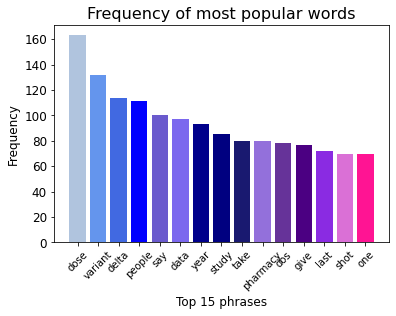

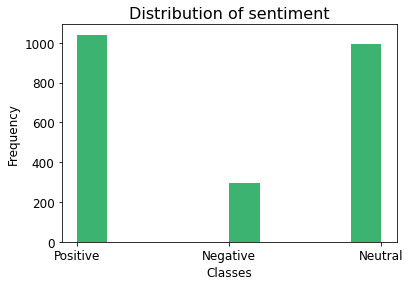

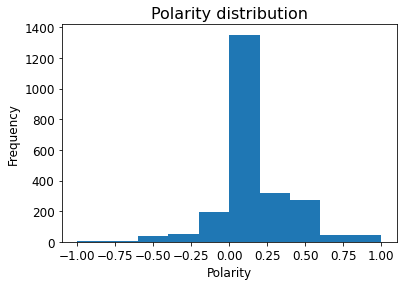

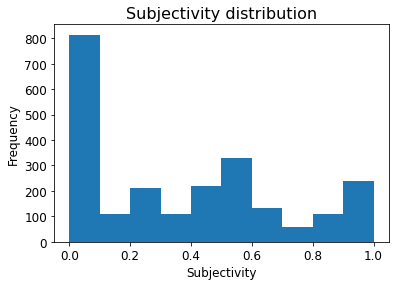

In [18]:
'''
https://stackoverflow.com/questions/3594740/finding-the-common-elements-of-a-list
'''
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure

    stpwrds = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
                         "you", "your", "yours", "yourself", "yourselves", 
                         "he", "him", "his", "himself", "she", "her", "hers", "herself", 
                         "it", "its", "itself", "they", "them", "their", "theirs", "themselves", 
                         "what", "which", "who", "whom", "this", "that", "these", "those", 
                         "am", "is", "are", "was", "were", "be", "been", "being", 
                         "have", "has", "had", "having", "do", "does", "did", "doing", 
                         "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                         "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", 
                         "into", "through", "during", "before", "after", "above", "below", 
                         "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
                         "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", 
                         "all", "any", "both", "each", "few", "more", "most", "other", "some", 
                         "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
                         "s", "t", "can", "will", "just", "don", "should", "now", 
                         'AstraZeneca', 'AstraZeneca vaccine', 'Astra Zeneca', 'AZ', 'astrazeneca', 'astra', 'Oxford', 'vaccine', 'vaccines', 'amp',
                         'COVID', 'covid', 'covid19', 'Pfizer', 'pfizer', 'BioNTech', 'pfizer vaccine', 'Moderna', 'Covid vaccine', 
                         'Moderna', 'moderna', 'moderna vaccine', 'Janssen vaccine', 'JNJ', 'jnj', 'j', 'Johnson', 'johnson', 'Janssen', 'janssen', 'may', 'get', '', '…']

    plot_lemmatized = ngramDataFrame.select("lemmatized_words").toPandas()
    plot_polar_sub = worldwide_combined_df.select("polarity", "subjectivity", "sentiment", round("polarity",2), round("subjectivity",2)).toPandas()
    plot_lemmatized4 = []

    for i,r in plot_lemmatized.iterrows():
        for row in r[0]:
            if row not in stpwrds: 
                plot_lemmatized4.append(row)

    word_counter = {}

    for word in plot_lemmatized4:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1

    popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
    top_15 = popular_words[:15]
    names = []

    for i in top_15:
        names.append(word_counter[i])


    import os
    os.chdir("/home/jovyan/dp2-2021s-teamboehm/Test/TestCombine")
    plt.bar(top_15, names, color=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'slateblue', 'mediumslateblue', 'darkblue', 'navy', "midnightblue", "mediumpurple", "rebeccapurple", "indigo", "blueviolet", "orchid", "deeppink"])
    plt.xlabel("Top 15 phrases", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Frequency of most popular words", fontsize=16)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=12)
    plt.rc('xtick', labelsize = 4)
    plt.savefig("plot_distribution.png", bbox_inches='tight')
    plt.show()
    plt.close()

    plot_sentiment = plot_polar_sub["sentiment"].hist(grid = False, color = ["mediumseagreen"])
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Distribution of sentiment", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fig = plot_sentiment.get_figure()
    fig.savefig("plot_sentiment.png", bbox_inches='tight')
    plt.show()
    plt.close()

    plot_polar_sub4 = plot_polar_sub["round(polarity, 2)"].hist(grid = False)
    plt.xlabel("Polarity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Polarity distribution", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fig = plot_polar_sub4.get_figure()
    fig.savefig("plot_polarity.png", bbox_inches='tight')
    plt.show()
    plt.close()

    plot_polar_sub1 = plot_polar_sub["round(subjectivity, 2)"].hist(grid = False)
    plt.xlabel("Subjectivity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Subjectivity distribution", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    fig = plot_polar_sub1.get_figure()
    fig.savefig("plot_subjectivity.png", bbox_inches='tight')
    plt.show()
    plt.close()
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [19]:
'''
https://spark.apache.org/docs/latest/ml-features.html
'''
try:
    # Creaating term frequency vector from punctuation cleaned array
    # Fit a CountVectorizerModel from the corpus
    countvect = CountVectorizer(inputCol="punc_cleaned", outputCol="features")
    model = countvect.fit(ngramDataFrame)
    FeaturizedData = model.transform(ngramDataFrame)

    # string indexer: creates numeric indices from textual labels
    label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
    indexedDataFrame = label_stringIdx.fit(FeaturizedData).transform(FeaturizedData)
    indexedDataFrame.select("text", "words", "filtered_words", "punc_cleaned", "lemmatized_words", "features", "sentiment", "label").show(5, vertical=True, truncate = False)
except: 
    print("Unexpected error:", sys.exc_info()[0])

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------
 text             | The Pfizer-BioNTech and Moderna Covid-19 vaccines may protect against the coronavirus for years, a study of more than a dozen…                      
 words            | [the, pfizer-biontech, and, moderna, covid-19, vaccines, may, protect, against, the, coronavirus, for, years,, a, study, of, more, than, a, dozen…] 
 filtered_words   | [pfizer-biontech, moderna, covid-19, vaccines, may, protect, coronavirus, years,, study, dozen…]                                                    
 punc_cleaned     | [pfizerbiontech, moderna, covid19, vaccines, may, protect, coronavirus, years, study, dozen…]                                                       
 lemmatized_words | [pfizerbiontech, moderna, covid19, vaccine, may, protect, coronavirus, year, study, dozen…]                                            

In [20]:
# distribution by labels
indexedDataFrame.groupBy("label") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1040|
|  1.0|  993|
|  2.0|  296|
+-----+-----+



In [21]:
# distribution by sentiment classes
indexedDataFrame.groupBy("sentiment") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+---------+-----+
|sentiment|count|
+---------+-----+
| Positive| 1040|
|  Neutral|  993|
| Negative|  296|
+---------+-----+



## Classification Models

In [22]:
try:
    # Splitting the final dataframe into test and train data
    # set seed for reproducibility
    print((indexedDataFrame.count(), len(indexedDataFrame.columns)))
    splits = indexedDataFrame.randomSplit([0.7, 0.3], seed = 123)
    #print(type(splits))
    #splits[0].show(truncate=True)
    #splits[1].show(truncate=True)
    trainingData = splits[0]
    testData = splits[1]
    print("Training Dataset Count: " + str(trainingData.count()))
    print("Test Dataset Count: " + str(testData.count()))
except: 
    print("Unexpected error:", sys.exc_info()[0])

(2329, 15)
Training Dataset Count: 1657
Test Dataset Count: 672


In [23]:
indexedDataFrame.printSchema()

root
 |-- text: string (nullable = true)
 |-- date: date (nullable = true)
 |-- location: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- tweet_length: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- punc_cleaned: array (nullable = false)
 |    |-- element: string (containsNull = true)
 |-- lemmatized_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tokens: integer (nullable = true)
 |-- ngrams: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



## Logistic Regression

In [24]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    from pyspark.ml.classification import LogisticRegression

    mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
    mlrModel = mlr.fit(trainingData)
    
    # the model will make predictions and score on the test set; 
    # we print out the top 10 predictions with the highest probability
    predictions = mlrModel.transform(testData)
    predictions.filter(predictions['prediction'] == 0) \
        .select("filtered_words","sentiment","probability","label","prediction") \
        .orderBy("probability", ascending=False) \
        .show(n = 10, truncate = 30)

    # Print the coefficients and intercepts for logistic regression with multinomial family
    print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
    print("Multinomial intercepts: " + str(mlrModel.interceptVector))
except: 
    print("Unexpected error:", sys.exc_info()[0])

+------------------------------+---------+------------------------------+-----+----------+
|                filtered_words|sentiment|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[*an, actual, vaccine, appo...|  Neutral|[0.4471941454394767,0.42848...|  1.0|       0.0|
|[600,000, pfizer, vaccines,...|  Neutral|[0.4471941454394767,0.42848...|  1.0|       0.0|
|               [fucking, time]| Negative|[0.4471941454394767,0.42848...|  2.0|       0.0|
|[az, risk/benefit, balance,...|  Neutral|[0.4471941454394767,0.42848...|  1.0|       0.0|
|[az, second, shot, pun, sen...| Positive|[0.4471941454394767,0.42848...|  0.0|       0.0|
|[anyone, age, (approved, fo...|  Neutral|[0.4471941454394767,0.42848...|  1.0|       0.0|
|[astra, zeneca, isn't, good...| Positive|[0.4471941454394767,0.42848...|  0.0|       0.0|
|[moderna, 45, miles, home, ...| Negative|[0.4471941454394767,0.42848...|  2.0|       0.0|

In [25]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.2740210141729194

In [26]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    trainingSummary = mlrModel.summary

    # Obtain the objective per iteration
    objectiveHistory = trainingSummary.objectiveHistory
    print("objectiveHistory:")
    for objective in objectiveHistory:
        print(objective)

    # for multiclass Logistic Regression, we can inspect metrics on a per-label basis
    print("False positive rate by label:")
    for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("True positive rate by label:")
    for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("Precision by label:")
    for i, prec in enumerate(trainingSummary.precisionByLabel):
        print("label %d: %s" % (i, prec))

    print("Recall by label:")
    for i, rec in enumerate(trainingSummary.recallByLabel):
        print("label %d: %s" % (i, rec))

    print("F-measure by label:")
    for i, f in enumerate(trainingSummary.fMeasureByLabel()):
        print("label %d: %s" % (i, f))

    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
except: 
    print("Unexpected error:", sys.exc_info()[0])

objectiveHistory:
0.9822220752190302
0.9822218337491957
0.982221423534225
0.9822214212747918
0.9822214208212016
0.9822214207307118
0.9822214206658099
0.9822214206619335
False positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
True positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
Precision by label:
label 0: 0.4471937235968618
label 1: 0.0
label 2: 0.0
Recall by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
F-measure by label:
label 0: 0.6180150125104253
label 1: 0.0
label 2: 0.0
Accuracy: 0.4471937235968618
FPR: 0.4471937235968618
TPR: 0.4471937235968618
F-measure: 0.27637243468329825
Precision: 0.19998222642442645
Recall: 0.4471937235968618


## Cross Validation

In [27]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

    # Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
       .addGrid(mlr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
       .addGrid(mlr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
    #  .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
    #  .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
       .build())

    # Create 5-fold CrossValidator
    cv = CrossValidator(estimator=mlr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
    cvModel = cv.fit(trainingData)

    predictions = cvModel.transform(testData)
except: 
    print("Unexpected error:", sys.exc_info()[0])

In [28]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.8114624501741363

## Naive Bayes

In [29]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    from pyspark.ml.classification import NaiveBayes

    nb = NaiveBayes(smoothing=1)
    model = nb.fit(trainingData)
    predictions = model.transform(testData)
    predictions.filter(predictions['prediction'] == 0) \
        .select("filtered_words","sentiment","probability","label","prediction") \
        .orderBy("probability", ascending=False) \
        .show(n = 10, truncate = 30)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+------------------------------+---------+------------------------------+-----+----------+
|                filtered_words|sentiment|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[teacher, covid, vaccine, a...| Positive|[0.9999999996245053,1.27174...|  0.0|       0.0|
|[teacher, covid, vaccine, a...| Positive|[0.9999999996245053,1.27174...|  0.0|       0.0|
|[teacher, covid, vaccine, a...| Positive|[0.9999999996245053,1.27174...|  0.0|       0.0|
|[spoke, friends, mine, los,...| Positive|[0.9999999993750599,4.55901...|  0.0|       0.0|
|[brilliant, skit, perfectly...| Positive|[0.9999999984650507,5.45297...|  0.0|       0.0|
|[brilliant, skit, perfectly...| Positive|[0.9999999984650507,5.45297...|  0.0|       0.0|
|[brilliant, skit, perfectly...| Positive|[0.9999999984650507,5.45297...|  0.0|       0.0|
|[brilliant, skit, perfectly...| Positive|[0.9999999984650507,5.45297...|  0.0|       0.0|

In [30]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.73929414984011

## Random Forest

In [31]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    from pyspark.ml.classification import RandomForestClassifier

    rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

    # Train model with Training Data
    rfModel = rf.fit(trainingData)

    # Predict performance on Test Data
    predictions = rfModel.transform(testData)
    predictions.filter(predictions['prediction'] == 0) \
        .select("filtered_words","sentiment","probability","label","prediction") \
        .orderBy("probability", ascending=False) \
        .show(n = 10, truncate = 30)
except: 
    print("Unexpected error:", sys.exc_info()[0])

+------------------------------+---------+------------------------------+-----+----------+
|                filtered_words|sentiment|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|
|[pfizer, astrazeneca, vacci...| Positive|[0.5578192741339891,0.34931...|  0.0|       0.0|

In [32]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.5092295258809857

## Logistic Regression using TF-IDF Features

**New Pipeline**

In [33]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
https://spark.apache.org/docs/latest/ml-features.html
https://stackoverflow.com/questions/58038919/removing-punctuation-in-spark-dataframe
https://stackoverflow.com/questions/59850159/nltk-wordnet-lemmatization-with-pos-tag-on-pyspark-dataframe
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
'''
# new pipeline
try:
    # tokenizing 
    tokenizer = RegexTokenizer(inputCol="text", outputCol="words")
    wordsData = tokenizer.transform(worldwide_combined_df)

    # stop words
    add_stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", 
                     "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", 
                     "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
                     "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", 
                     "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", 
                     "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", 
                     "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", 
                     "s", "t", "can", "will", "just", "don", "should", "now"]
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words").setStopWords(add_stopwords)
    filteredData = remover.transform(wordsData)

    # remove punctuation
    def removePunctuation(column):
        return split(trim(lower(regexp_replace(concat_ws(" ", column),'\\p{Punct}', ''))), " ")

    filteredData = filteredData.withColumn("punc_cleaned", removePunctuation(filteredData.filtered_words))

    # lemmatization
    def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
                return 'a'
        elif treebank_tag.startswith('V'):
                return 'v'
        elif treebank_tag.startswith('N'):
                return 'n'
        elif treebank_tag.startswith('R'):
                return 'r'
        else:
        # As default pos in lemmatization is Noun
            return 'n'

    def lemmatization(data_str):
        # expects a string
        list_pos = 0
        cleaned_str = []
        lemmatizer = WordNetLemmatizer()
        #text = data_str.split()
        tagged_words = nltk.pos_tag(data_str)
        for word in tagged_words:
            lemma = lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1]))
            cleaned_str.append(lemma)
            list_pos += 1
        return cleaned_str

    sparkLemmer = udf(lambda x: lemmatization(x), ArrayType(StringType()))
    lemmaDataFrame = filteredData.withColumn("lemmatized_words", sparkLemmer(filteredData.punc_cleaned))

    countTokens = udf(lambda words: len(words), IntegerType())
    tokenizedData = lemmaDataFrame.withColumn("tokens", countTokens(col("lemmatized_words")))

    # bigrams
    ngram = NGram(n=2, inputCol="lemmatized_words", outputCol="ngrams")
    ngramDataFrame = ngram.transform(tokenizedData)

    # Creaating term frequency vector 
    # Fit a HashingTF from the corpus
    hashingTF = HashingTF(inputCol="punc_cleaned", outputCol="rawFeatures", numFeatures=10000)
    rawFeaturizedData = hashingTF.transform(ngramDataFrame)

    # Creating inverse document frequency 
    idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
    idfModel = idf.fit(rawFeaturizedData)
    rescaledData = idfModel.transform(rawFeaturizedData)

    # stringindexer
    label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
    indexedDataFrame = label_stringIdx.fit(rescaledData).transform(rescaledData)
    indexedDataFrame.select("text", "words", "filtered_words", "punc_cleaned", "lemmatized_words", "rawFeatures", "features", "sentiment", "label").show(5, vertical=True, truncate = False)
except: 
    print("Unexpected error:", sys.exc_info()[0])

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 text             | The Pfizer-BioNTech and Moderna Covid-19 vaccines may protect against the coronavirus for years, a study of more than a dozen…                                                                                                                                                               
 words            | [the, pfizer-biontech, and, moderna, covid-19, vaccines, may, protect, against, the, coronavirus, for, years,, a, study, of, more, than, a, dozen…]                                                                                                                                          
 filtered_words   | [pfizer-biontech, moderna, covid-19, vaccines, may, protect, c

In [34]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    # Splitting into test and train data
    splits = indexedDataFrame.randomSplit([0.7, 0.3], seed = 123)
    trainingData = splits[0]
    testData = splits[1]

    mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
    mlrModel = mlr.fit(trainingData)
    predictions = mlrModel.transform(testData)
    predictions.filter(predictions['prediction'] == 0) \
        .select("filtered_words","sentiment","probability","label","prediction") \
        .orderBy("probability", ascending=False) \
        .show(n = 10, truncate = 30)

    # Print the coefficients and intercepts for logistic regression with multinomial family
    print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
    print("Multinomial intercepts: " + str(mlrModel.interceptVector))
except: 
    print("Unexpected error:", sys.exc_info()[0])

+------------------------------+---------+------------------------------+-----+----------+
|                filtered_words|sentiment|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[*an, actual, vaccine, appo...|  Neutral|[0.4471940507476786,0.42848...|  1.0|       0.0|
|[600,000, pfizer, vaccines,...|  Neutral|[0.4471940507476786,0.42848...|  1.0|       0.0|
|               [fucking, time]| Negative|[0.4471940507476786,0.42848...|  2.0|       0.0|
|[az, risk/benefit, balance,...|  Neutral|[0.4471940507476786,0.42848...|  1.0|       0.0|
|[az, second, shot, pun, sen...| Positive|[0.4471940507476786,0.42848...|  0.0|       0.0|
|[anyone, age, (approved, fo...|  Neutral|[0.4471940507476786,0.42848...|  1.0|       0.0|
|[astra, zeneca, isn't, good...| Positive|[0.4471940507476786,0.42848...|  0.0|       0.0|
|[moderna, 45, miles, home, ...| Negative|[0.4471940507476786,0.42848...|  2.0|       0.0|

In [35]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


0.2740210141729194

In [36]:
'''
https://spark.apache.org/docs/latest/ml-classification-regression.html
'''
try:
    trainingSummary = mlrModel.summary

    # Obtain the objective per iteration
    objectiveHistory = trainingSummary.objectiveHistory
    print("objectiveHistory:")
    for objective in objectiveHistory:
        print(objective)

    # for multiclass Logistic Regression, we can inspect metrics on a per-label basis
    print("False positive rate by label:")
    for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("True positive rate by label:")
    for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("Precision by label:")
    for i, prec in enumerate(trainingSummary.precisionByLabel):
        print("label %d: %s" % (i, prec))

    print("Recall by label:")
    for i, rec in enumerate(trainingSummary.recallByLabel):
        print("label %d: %s" % (i, rec))

    print("F-measure by label:")
    for i, f in enumerate(trainingSummary.fMeasureByLabel()):
        print("label %d: %s" % (i, f))

    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))
except: 
    print("Unexpected error:", sys.exc_info()[0])

objectiveHistory:
0.9822220752190302
0.9822219052463248
0.9822214243313637
0.9822214210304288
0.9822214207034797
0.9822214206798588
0.9822214206617971
False positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
True positive rate by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
Precision by label:
label 0: 0.4471937235968618
label 1: 0.0
label 2: 0.0
Recall by label:
label 0: 1.0
label 1: 0.0
label 2: 0.0
F-measure by label:
label 0: 0.6180150125104253
label 1: 0.0
label 2: 0.0
Accuracy: 0.4471937235968618
FPR: 0.4471937235968618
TPR: 0.4471937235968618
F-measure: 0.27637243468329825
Precision: 0.19998222642442645
Recall: 0.4471937235968618
